In [12]:
from __future__ import print_function
import os
import sys
import time
import numpy as np
import re
import faiss
import inspect
from multiprocessing.dummy import Pool as ThreadPool
from matplotlib import pyplot

In [ ]:
"""
Section 1: 
An example of computing expected scanned ratio of a single index

  e.g., suppose the query vectors has the same distribution as the trained vectors, 
    then the larger a Voronoi cell, the more likely they will be searched
  e.g., searching 32 cells over 8192 in 100 M dataset will not scan 32 / 8192 * 1e8 entries on average,
    we need to scan more
"""

In [2]:
dbname        = 'SIFT100M'
index_key     = 'OPQ16,IVF8192,PQ16'
parametersets = ['nprobe=1', 'nprobe=32']

In [3]:
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]


def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]

def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()


tmpdir = '../trained_CPU_indexes/bench_cpu_{}_{}'.format(dbname, index_key)

if not os.path.isdir(tmpdir):
    raise("%s does not exist")


#################################################################
# Prepare dataset
#################################################################


print("Preparing dataset", dbname)

if dbname.startswith('SIFT'):
    # SIFT1M to SIFT1000M
    dbsize = int(dbname[4:-1])
    xb = mmap_bvecs('../bigann/bigann_base.bvecs')
    xq = mmap_bvecs('../bigann/bigann_query.bvecs')
    xt = mmap_bvecs('../bigann/bigann_learn.bvecs')

    # trim xb to correct size
    xb = xb[:dbsize * 1000 * 1000]

    gt = ivecs_read('../bigann/gnd/idx_%dM.ivecs' % dbsize)

elif dbname == 'Deep1B':
    xb = mmap_fvecs('../deep1b/base.fvecs')
    xq = mmap_fvecs('../deep1b/deep1B_queries.fvecs')
    xt = mmap_fvecs('../deep1b/learn.fvecs')
    # deep1B's train is is outrageously big
    xt = xt[:10 * 1000 * 1000]
    gt = ivecs_read('../deep1b/deep1B_groundtruth.ivecs')

else:
    print('unknown dataset', dbname, file=sys.stderr)
    sys.exit(1)


print("sizes: B %s Q %s T %s gt %s" % (
    xb.shape, xq.shape, xt.shape, gt.shape))

nq, d = xq.shape
nb, d = xb.shape
assert gt.shape[0] == nq


#################################################################
# Load Index
#################################################################

def get_populated_index():

    filename = "%s/%s_%s_populated.index" % (
        tmpdir, dbname, index_key)

    if not os.path.exists(filename):
        raise("Index does not exist!")
    else:
        print("loading", filename)
        index = faiss.read_index(filename)
    return index


Preparing dataset SIFT100M
sizes: B (100000000, 128) Q (10000, 128) T (100000000, 128) gt (10000, 1000)


In [4]:
#################################################################
# Perform searches
#################################################################

index = get_populated_index()

ps = faiss.ParameterSpace()
ps.initialize(index)

# make sure queries are in RAM
xq = xq.astype('float32').copy()

# a static C++ object that collects statistics about searches
ivfpq_stats = faiss.cvar.indexIVFPQ_stats
ivf_stats = faiss.cvar.indexIVF_stats


# we do queries in a single thread
faiss.omp_set_num_threads(1)

print(' ' * len(parametersets[0]), '\t', 'R@1    R@10   R@100     time    %pass')

for param in parametersets:
    print(param, '\t', end=' ')
    sys.stdout.flush()
    ps.set_index_parameters(index, param)
    t0 = time.time()
    ivfpq_stats.reset()
    ivf_stats.reset()
    D, I = index.search(xq, 100)
    t1 = time.time()
    for rank in 1, 10, 100:
        n_ok = (I[:, :rank] == gt[:, :1]).sum()
        print("%.4f" % (n_ok / float(nq)), end=' ')
    print("%8.3f  " % ((t1 - t0) * 1000.0 / nq), end=' ')
    print("%5.2f" % (ivfpq_stats.n_hamming_pass * 100.0 / ivf_stats.ndis))

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF8192,PQ16/SIFT100M_OPQ16,IVF8192,PQ16_populated.index
         	 R@1    R@10   R@100     time    %pass
nprobe=1 	 0.2049 0.3759 0.3989    0.297    0.00
nprobe=32 	 0.3509 0.8288 0.9645    5.724    0.00


In [15]:
downcasted_index = faiss.downcast_index(index.index)
invlists = downcasted_index.invlists

In [17]:
def get_invlist(invlists, l):
    """ 
    returns the (vector IDs set, PQ cose set) of list ID "l"
    list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
    list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)
    
    That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
    To avoid this, just clone the output arrays on output. 
    """
    ls = invlists.list_size(l)
    list_vec_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
    list_PQ_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
    list_PQ_codes = list_PQ_codes.reshape(-1, invlists.code_size)
    return list_vec_ids, list_PQ_codes

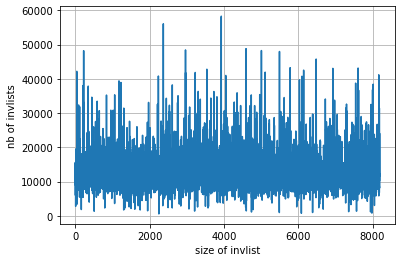

In [27]:
cell_entry_num_list = [invlists.list_size(l) for l in range(invlists.nlist)]
pyplot.step(np.arange(len(cell_entry_num_list)), cell_entry_num_list)
pyplot.xlabel('size of invlist')
pyplot.ylabel('nb of invlists')
pyplot.grid()

In [28]:
print(cell_entry_num_list)

[9035, 12731, 8983, 15326, 15461, 5973, 13444, 10582, 15699, 11621, 13614, 2772, 9847, 11357, 12707, 9798, 13343, 10178, 12772, 9817, 10083, 11972, 5730, 8354, 10454, 19596, 15131, 8526, 11471, 9139, 11864, 9979, 10806, 9095, 7111, 11654, 8370, 8887, 15526, 10380, 8047, 10253, 42189, 11442, 15277, 10455, 3388, 10450, 12106, 10627, 12456, 10245, 11279, 9766, 14038, 21918, 22268, 12357, 14108, 7491, 11765, 10951, 11115, 12774, 8361, 7402, 13647, 22245, 11764, 10845, 11320, 8919, 18750, 11195, 10141, 9359, 10249, 11084, 13944, 11763, 9987, 12662, 17536, 10664, 8693, 8751, 9537, 10763, 11883, 12458, 32349, 8088, 30637, 11987, 19952, 14924, 11007, 8844, 7533, 14039, 13723, 12392, 12337, 10973, 12490, 24690, 11420, 14335, 9332, 10449, 12759, 13282, 8218, 12552, 9362, 5449, 9976, 31865, 17641, 9764, 9290, 12845, 8301, 22469, 8237, 11010, 14659, 12836, 12196, 9380, 11308, 11134, 10061, 10866, 9258, 10372, 19900, 11348, 12320, 16661, 6152, 9922, 11599, 10894, 10553, 17203, 18151, 10648, 8483, 9

In [29]:
# report the unbalanced factor
#   e.g., suppose the query vectors has the same distribution as the trained vectors, 
#     then the larger a Voronoi cell, the more likely they will be searched
#   e.g., searching 32 cells over 8192 in 100 M dataset will not scan 32 / 8192 * 1e8 entries on average,
#     we need to scan more
nlist = len(cell_entry_num_list)
entry_num = 1e8 # 100 M dataset
expectation_per_cluster = 0
average_per_cluster = entry_num / nlist
for c in cell_entry_num_list:
    expectation_per_cluster += c * c / entry_num
    
print("average_per_cluster: {}\nexpectation_per_cluster: {}\nextra scanned ratio: {}".format(
    average_per_cluster, expectation_per_cluster, expectation_per_cluster / average_per_cluster))

average_per_cluster: 12207.03125
expectation_per_cluster: 13865.866380959984
extra scanned ratio: 1.135891773928242


In [ ]:
"""
Section 2:

Verify this expected ratio by 10000 query vectors
"""

In [24]:
def get_sub_quantizer_centroids(index):
    """
    return the sub-quantizer centroids, 
    shape = (m, 256, d / m)
    e.g., d=128, m=16 -> (16, 256, 8)
    """
    pq = index.pq
    cen = faiss.vector_to_array(pq.centroids)
    cen = cen.reshape(pq.M, pq.ksub, pq.dsub)
    
    return cen

def get_coarse_quantizer_centroids(index):
    """
    return the coarse-grained quantizer centroids,
    shape = (nlist, d),
    e.g., nlist=1024, d=128 -> (1024, 128)
    """
    coarse_quantizer = faiss.downcast_index(index.quantizer)
    coarse_cen = faiss.vector_to_array(coarse_quantizer.xb)

    coarse_cen = coarse_cen.reshape(coarse_quantizer.ntotal, coarse_quantizer.d)
    return coarse_cen

# Get Sub quantizer info
sub_cen = get_sub_quantizer_centroids(downcasted_index)
print("==== Sub-quantizer ====\n{}\n\nshape:{}\n".format(sub_cen, sub_cen.shape))

# Get Coarse quantizer info
coarse_cen = get_coarse_quantizer_centroids(downcasted_index)
print("==== Coarse-quantizer ====\n{}\n\nshape:{}\n".format(coarse_cen, coarse_cen.shape))

==== Sub-quantizer ====
[[[-30.197075   -23.236074   -13.366585   ... -11.393365     5.8771296
   -18.89725   ]
  [-33.022923   -15.39339      9.522758   ...  -8.383547    16.251562
    12.538808  ]
  [-14.867078    -2.4835837   -1.7066059  ...   3.1077738   19.915678
   -16.846704  ]
  ...
  [ 29.21712     13.204249     2.3176963  ...  16.067656   -24.286322
    30.081974  ]
  [ 28.375912    13.999012   -11.073188   ...  -4.282479   -21.07674
     6.6677904 ]
  [ 28.037931    42.105015     1.0285904  ...  35.699448    13.697935
   -14.478575  ]]

 [[ 20.051786    -8.370474     0.5161412  ...  12.963359   -15.200961
    27.656296  ]
  [ 15.461749   -10.884682     5.703733   ... -14.309333   -28.87946
     9.411468  ]
  [  6.2166452   -9.853486    16.709171   ...   9.081562   -18.439915
     7.429808  ]
  ...
  [-28.226736    26.75037    -23.633837   ...  -0.46722895  56.466084
   -13.462248  ]
  [-16.889128    30.844292    -5.331582   ...  17.001925    35.040524
   -19.33138   ]
  [-21

In [38]:
"""
Self-implemented functions to search a query vectors
"""

def distance_full_vec(v1, v2):
    """Given 2 full vector, return their L2 distance"""
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    dist = np.sum(v_diff * v_diff)
    return dist


def single_query_scanned_id(q_vec, nprobe, coarse_cen):
    """
    Search a single query vector, return the list of IDs of cells to scan
    """
    
    # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])

    # Estimate distance by ADC
    closest_cell_list = coarse_dist_ls[:nprobe]
    closest_cell_id_list = [ID for (dist, ID) in closest_cell_list]
    
    return closest_cell_id_list

def batch_query_scanned_num(q_vecs, nprobe, nlist, total_entry_num, coarse_cen, cell_entry_num_list):
    """
    for a batch of queries, how many total scanned entries?
    """
    id_list_batch = []
    for q_vec in q_vecs:
        id_list_batch += single_query_scanned_id(q_vec, nprobe, coarse_cen)
    
    total_scanned_entries = 0
    for ID in id_list_batch:
        total_scanned_entries += cell_entry_num_list[ID]
    average_scanned_entries = nprobe / nlist * total_entry_num * len(q_vecs)
    extra_scanned_ratio = total_scanned_entries / average_scanned_entries
    
        
    print("average_scanned_entries: {}\ntotal_scanned_entries: {}\nextra scanned ratio: {}".format(
        average_scanned_entries, total_scanned_entries, total_scanned_entries / average_scanned_entries))

    return total_scanned_entries, average_scanned_entries

In [32]:
""" Get OPQ Matrix """
linear_trans = faiss.downcast_VectorTransform(index.chain.at(0))
OPQ_mat = faiss.vector_to_array(linear_trans.A)
OPQ_mat = OPQ_mat.reshape((128,128))
OPQ_mat = np.array(OPQ_mat, dtype=np.float32)
print(OPQ_mat, OPQ_mat.shape)

[[-0.04185106  0.03428996  0.01463496 ...  0.26744068  0.08420503
  -0.12249091]
 [ 0.03530787  0.08281487 -0.05807371 ... -0.08664993 -0.05088573
  -0.24373505]
 [ 0.04926687  0.01517367 -0.00573028 ...  0.00100601  0.03905569
  -0.13516347]
 ...
 [ 0.10964511  0.08982475 -0.02009742 ... -0.0578454  -0.0549995
   0.04094499]
 [-0.12942526  0.17826557 -0.02329139 ... -0.0937097  -0.03088556
   0.12256143]
 [-0.1314367   0.14714412  0.01808932 ...  0.02709483 -0.03784304
  -0.10600516]] (128, 128)


In [33]:
""" Transform input vectors """
assert xq.shape[0] == 10000 and xq.shape[1] == 128

xq_transformed = np.zeros((10000,128), dtype=np.float32)

for n in range(10000):
    for d in range(128): 
        # a row of input vector inner product a row of OPQ matrix
        xq_transformed[n,d] = np.inner(xq[n], OPQ_mat[d])
        
print(xq_transformed.shape)

(10000, 128)


In [41]:
nprobe = 17
total_entry_num = 1e8

total_scanned_entries, average_scanned_entries = \
    batch_query_scanned_num(xq_transformed, nprobe, nlist, total_entry_num, coarse_cen, cell_entry_num_list)

average_scanned_entries: 2075195312.5
total_scanned_entries: 2270772521
extra scanned ratio: 1.0942452054136471


In [42]:
"""
8192, OPQ, 100M
computed expected scan ratio = 1.135891773928242
real scan ratio = 1.0942452054136471 (10000 queries)
"""

'\n8192, OPQ, 100M\ncomputed expected scan ratio = 1.135891773928242\nreal scan ratio = 1.0942452054136471 (10000 queries)\n'

In [ ]:
"""
Section 3

Compute the expected scan ratio of a range of indexes
"""

In [ ]:
"""
Section 3.1: with OPQ
"""

In [46]:
total_million_entries = 100
dbname        = 'SIFT{}M'.format(total_million_entries)

for nlist in [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]:
    
    index_key = 'OPQ16,IVF{},PQ16'.format(nlist)

    tmpdir = '../trained_CPU_indexes/bench_cpu_{}_{}'.format(dbname, index_key)

    if not os.path.isdir(tmpdir):
        raise("%s does not exist")

    def get_populated_index():

        filename = "%s/%s_%s_populated.index" % (
            tmpdir, dbname, index_key)

        if not os.path.exists(filename):
            raise("Index does not exist!")
        else:
            print("loading", filename)
            index = faiss.read_index(filename)
        return index
    
    
    index = get_populated_index()
    downcasted_index = faiss.downcast_index(index.index)
    invlists = downcasted_index.invlists
    
    def get_invlist(invlists, l):
        """ 
        returns the (vector IDs set, PQ cose set) of list ID "l"
        list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
        list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)

        That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
        To avoid this, just clone the output arrays on output. 
        """
        ls = invlists.list_size(l)
        list_vec_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
        list_PQ_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
        list_PQ_codes = list_PQ_codes.reshape(-1, invlists.code_size)
        return list_vec_ids, list_PQ_codes

    cell_entry_num_list = [invlists.list_size(l) for l in range(invlists.nlist)]
    expectation_per_cluster = 0
    total_entries = total_million_entries * 1e6
    average_per_cluster = total_entries / nlist
    for c in cell_entry_num_list:
        expectation_per_cluster += c * c / total_entries
    
    print("\n" + 50 * "=")
    print(dbname, index_key)
    print("average_per_cluster: {}\nexpectation_per_cluster: {}\nextra scanned ratio: {}".format(
        average_per_cluster, expectation_per_cluster, expectation_per_cluster / average_per_cluster))
    print(50 * "=" + '\n')

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF1024,PQ16/SIFT100M_OPQ16,IVF1024,PQ16_populated.index

SIFT100M OPQ16,IVF1024,PQ16
average_per_cluster: 97656.25
expectation_per_cluster: 107665.61468235996
extra scanned ratio: 1.102495894347366

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF2048,PQ16/SIFT100M_OPQ16,IVF2048,PQ16_populated.index

SIFT100M OPQ16,IVF2048,PQ16
average_per_cluster: 48828.125
expectation_per_cluster: 54914.02183137988
extra scanned ratio: 1.12463916710666

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF4096,PQ16/SIFT100M_OPQ16,IVF4096,PQ16_populated.index

SIFT100M OPQ16,IVF4096,PQ16
average_per_cluster: 24414.0625
expectation_per_cluster: 27417.57728273999
extra scanned ratio: 1.12302396550103

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF8192,PQ16/SIFT100M_OPQ16,IVF8192,PQ16_populated.index

SIFT100M OPQ16,IVF8192,PQ16
average_per_cluster: 12207.03125
expectation_per_cluster: 13865.866380959984
extra scanned 

In [ ]:
"""
SIFT 100M Result (with OPQ):

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF1024,PQ16/SIFT100M_OPQ16,IVF1024,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF1024,PQ16
average_per_cluster: 97656.25
expectation_per_cluster: 107665.61468235996
extra scanned ratio: 1.102495894347366
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF2048,PQ16/SIFT100M_OPQ16,IVF2048,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF2048,PQ16
average_per_cluster: 48828.125
expectation_per_cluster: 54914.02183137988
extra scanned ratio: 1.12463916710666
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF4096,PQ16/SIFT100M_OPQ16,IVF4096,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF4096,PQ16
average_per_cluster: 24414.0625
expectation_per_cluster: 27417.57728273999
extra scanned ratio: 1.12302396550103
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF8192,PQ16/SIFT100M_OPQ16,IVF8192,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF8192,PQ16
average_per_cluster: 12207.03125
expectation_per_cluster: 13865.866380959984
extra scanned ratio: 1.135891773928242
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF16384,PQ16/SIFT100M_OPQ16,IVF16384,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF16384,PQ16
average_per_cluster: 6103.515625
expectation_per_cluster: 7035.608760120029
extra scanned ratio: 1.1527141392580655
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF32768,PQ16/SIFT100M_OPQ16,IVF32768,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF32768,PQ16
average_per_cluster: 3051.7578125
expectation_per_cluster: 3491.623955880011
extra scanned ratio: 1.1441353378627621
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF65536,PQ16/SIFT100M_OPQ16,IVF65536,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF65536,PQ16
average_per_cluster: 1525.87890625
expectation_per_cluster: 1741.2025398600224
extra scanned ratio: 1.1411144965226643
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF131072,PQ16/SIFT100M_OPQ16,IVF131072,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF131072,PQ16
average_per_cluster: 762.939453125
expectation_per_cluster: 875.6090591400201
extra scanned ratio: 1.1476783059960072
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_OPQ16,IVF262144,PQ16/SIFT100M_OPQ16,IVF262144,PQ16_populated.index

==================================================
SIFT100M OPQ16,IVF262144,PQ16
average_per_cluster: 381.4697265625
expectation_per_cluster: 440.34511577997296
extra scanned ratio: 1.1543383003102523
==================================================

"""

In [47]:
"""
Section 3.2 without OPQ
"""

'\nSection 3.2 without OPQ\n'

In [48]:

total_million_entries = 100
dbname        = 'SIFT{}M'.format(total_million_entries)

for nlist in [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]:
    
    index_key = 'IVF{},PQ16'.format(nlist)

    tmpdir = '../trained_CPU_indexes/bench_cpu_{}_{}'.format(dbname, index_key)

    if not os.path.isdir(tmpdir):
        raise("%s does not exist")

    def get_populated_index():

        filename = "%s/%s_%s_populated.index" % (
            tmpdir, dbname, index_key)

        if not os.path.exists(filename):
            raise("Index does not exist!")
        else:
            print("loading", filename)
            index = faiss.read_index(filename)
        return index
    
    
    index = get_populated_index()
    invlists = index.invlists
    
    def get_invlist(invlists, l):
        """ 
        returns the (vector IDs set, PQ cose set) of list ID "l"
        list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
        list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)

        That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
        To avoid this, just clone the output arrays on output. 
        """
        ls = invlists.list_size(l)
        list_vec_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
        list_PQ_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
        list_PQ_codes = list_PQ_codes.reshape(-1, invlists.code_size)
        return list_vec_ids, list_PQ_codes

    cell_entry_num_list = [invlists.list_size(l) for l in range(invlists.nlist)]
    expectation_per_cluster = 0
    total_entries = total_million_entries * 1e6
    average_per_cluster = total_entries / nlist
    for c in cell_entry_num_list:
        expectation_per_cluster += c * c / total_entries
    
    print("\n" + 50 * "=")
    print(dbname, index_key)
    print("average_per_cluster: {}\nexpectation_per_cluster: {}\nextra scanned ratio: {}".format(
        average_per_cluster, expectation_per_cluster, expectation_per_cluster / average_per_cluster))
    print(50 * "=" + '\n')

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF1024,PQ16/SIFT100M_IVF1024,PQ16_populated.index

SIFT100M IVF1024,PQ16
average_per_cluster: 97656.25
expectation_per_cluster: 107649.48875959993
extra scanned ratio: 1.1023307648983034

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF2048,PQ16/SIFT100M_IVF2048,PQ16_populated.index

SIFT100M IVF2048,PQ16
average_per_cluster: 48828.125
expectation_per_cluster: 54908.89875494005
extra scanned ratio: 1.1245342465011723

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF4096,PQ16/SIFT100M_IVF4096,PQ16_populated.index

SIFT100M IVF4096,PQ16
average_per_cluster: 24414.0625
expectation_per_cluster: 27418.37041436005
extra scanned ratio: 1.1230564521721877

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF8192,PQ16/SIFT100M_IVF8192,PQ16_populated.index

SIFT100M IVF8192,PQ16
average_per_cluster: 12207.03125
expectation_per_cluster: 13865.552036639967
extra scanned ratio: 1.135866022841546

loading ../trained_CPU_indexes/bench_cpu_

In [ ]:
"""
SIFT 100M Result (without OPQ):

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF1024,PQ16/SIFT100M_IVF1024,PQ16_populated.index

==================================================
SIFT100M IVF1024,PQ16
average_per_cluster: 97656.25
expectation_per_cluster: 107649.48875959993
extra scanned ratio: 1.1023307648983034
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF2048,PQ16/SIFT100M_IVF2048,PQ16_populated.index

==================================================
SIFT100M IVF2048,PQ16
average_per_cluster: 48828.125
expectation_per_cluster: 54908.89875494005
extra scanned ratio: 1.1245342465011723
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF4096,PQ16/SIFT100M_IVF4096,PQ16_populated.index

==================================================
SIFT100M IVF4096,PQ16
average_per_cluster: 24414.0625
expectation_per_cluster: 27418.37041436005
extra scanned ratio: 1.1230564521721877
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF8192,PQ16/SIFT100M_IVF8192,PQ16_populated.index

==================================================
SIFT100M IVF8192,PQ16
average_per_cluster: 12207.03125
expectation_per_cluster: 13865.552036639967
extra scanned ratio: 1.135866022841546
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF16384,PQ16/SIFT100M_IVF16384,PQ16_populated.index

==================================================
SIFT100M IVF16384,PQ16
average_per_cluster: 6103.515625
expectation_per_cluster: 7033.591676980025
extra scanned ratio: 1.1523836603564073
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF32768,PQ16/SIFT100M_IVF32768,PQ16_populated.index

==================================================
SIFT100M IVF32768,PQ16
average_per_cluster: 3051.7578125
expectation_per_cluster: 3491.312950360007
extra scanned ratio: 1.1440334275739672
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF65536,PQ16/SIFT100M_IVF65536,PQ16_populated.index

==================================================
SIFT100M IVF65536,PQ16
average_per_cluster: 1525.87890625
expectation_per_cluster: 1741.1330532600166
extra scanned ratio: 1.1410689577844846
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF131072,PQ16/SIFT100M_IVF131072,PQ16_populated.index

==================================================
SIFT100M IVF131072,PQ16
average_per_cluster: 762.939453125
expectation_per_cluster: 875.5782000000119
extra scanned ratio: 1.1476378583040157
==================================================

loading ../trained_CPU_indexes/bench_cpu_SIFT100M_IVF262144,PQ16/SIFT100M_IVF262144,PQ16_populated.index

==================================================
SIFT100M IVF262144,PQ16
average_per_cluster: 381.4697265625
expectation_per_cluster: 440.3409754199744
extra scanned ratio: 1.1543274466049378
==================================================
"""